In [1]:
import torch
from datasets import load_dataset
from IPython.display import display, Image, update_display, HTML
from torchvision.transforms import ToPILImage, RandomCrop, PILToTensor
from fastprogress.fastprogress import master_bar, progress_bar

In [2]:
device = "cuda"
class Args:
    def __init__(self):
        self.batch_size = 8
        self.grad_accum_steps = 8
        self.plot_update = 32
        self.min_lr = 1e-7
        self.max_lr = 2e-5
        self.warmup_steps = 2000
        self.weight_decay = 0.
        self.epochs = 10
        self.channels=3
        self.num_workers=12
        self.λ = 0.01
        self.patience = 128
args = Args()

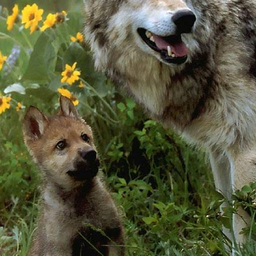

In [3]:
train_dataset = load_dataset("danjacobellis/imagenet_hq", split="train")
valid_dataset = load_dataset("danjacobellis/imagenet_hq", split="validation")

def collate_fn(batch):
    return torch.cat([
        PILToTensor()(RandomCrop(256)(sample['image'])).unsqueeze(0) for sample in batch
    ])

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset.select([1,7,30,33]),
    batch_size=1,
    num_workers=12,
    drop_last=True,
    shuffle=False,
    collate_fn=collate_fn
)

valid_batch = next(iter(dataloader_valid))
valid_batch = valid_batch/255
valid_batch = valid_batch - 0.5
valid_batch = valid_batch.to(device)

for img in valid_batch:
    display(ToPILImage()(img+0.5))

In [4]:
import torch
import torch.nn as nn
import numpy as np
import einops
from pytorch_wavelets import DTCWTForward, DTCWTInverse
import diffusers.models.autoencoders as autoencoders 

class Round(nn.Module):
    def __init__(self):
        super(Round, self).__init__()
    def forward(self, x):
        if self.training:
            noise = torch.rand_like(x) - 0.5
            return x + noise
        else:
            return torch.round(x)
            
class Walloc(nn.Module):
    def __init__(self, in_channels=3, J=4, latent_dims=[12,36,72,72,72]):
        super().__init__()
        self.in_channels = in_channels
        self.J = J
        self.latent_dims = latent_dims
        self.wavelet_analysis  = DTCWTForward(J=J, biort='near_sym_b', qshift='qshift_b')
        self.wavelet_synthesis = DTCWTInverse(biort='near_sym_b', qshift='qshift_b')
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        
        for i, latent_dim in enumerate(latent_dims):
            channels = in_channels if i==0 else 12*in_channels
            rr = 2 if i==0 else i
            norm_num_groups = round(latent_dim/channels)
            self.encoders.append(nn.Sequential(
                autoencoders.autoencoder_kl.Encoder(
                    in_channels = channels,
                    out_channels = latent_dim,
                    down_block_types = rr*('DownEncoderBlock2D',),
                    block_out_channels = rr*(latent_dim,),
                    layers_per_block = 2,
                    norm_num_groups = norm_num_groups,
                    act_fn = 'silu',
                    double_z = False,
                    mid_block_add_attention=True,
                ),
                torch.nn.Hardtanh(min_val=-7.499, max_val=7.499),
                Round()
            ))
            self.decoders.append(nn.Sequential(
                autoencoders.autoencoder_kl.Decoder(
                    in_channels = latent_dim,
                    out_channels = channels,
                    up_block_types = rr*('UpDecoderBlock2D',),
                    block_out_channels = rr*(latent_dim,),
                    layers_per_block = 2,
                    norm_num_groups = norm_num_groups,
                    act_fn = 'silu',
                    mid_block_add_attention=True,
                ),
                torch.nn.Hardtanh(min_val=-0.5, max_val=0.5),
            ))

    def multi_res_encode(self, x):
        L, H = self.wavelet_analysis(x)
        X = [L] + [einops.rearrange(h, 'b c o h w ri -> b (c o ri) h w') for h in reversed(H)]
        Z = [self.encoders[i](Xi) for i, Xi in enumerate(X)]
        Z = torch.cat(Z, dim=1)
        return Z

    def multi_res_decode(self,Z):
        Z = torch.split(Z, self.latent_dims, dim=1)
        X_hat = [self.decoders[i](Zi) for i, Zi in enumerate(Z)]
        L_hat = X_hat[0]
        H_hat = [einops.rearrange(h, 'b (c o ri) h w -> b c o h w ri', c=self.in_channels, o=6, ri=2) for h in reversed(X_hat[1:])]
        x_hat = self.wavelet_synthesis((L_hat, H_hat))
        return x_hat
    
    def forward(self, x):
        return self.multi_res_decode(self.multi_res_encode(x))

In [5]:
codec = Walloc().to(device)
sum(p.numel() for p in codec.parameters())/1e6

6.766851

In [6]:
with torch.no_grad():
    Z = codec.multi_res_encode(valid_batch)
    x_hat = codec.multi_res_decode(Z)

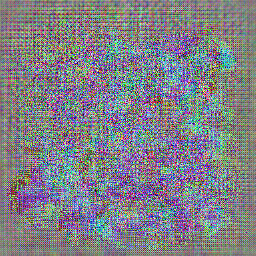

In [7]:
for img in x_hat:
    display(ToPILImage()(img+0.5))